In [1]:
import os
import sys

import math
from datetime import timezone, datetime

import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import mplfinance as mpf
import numba
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp
import seaborn as sns
import talib

from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit

In [2]:
from timescaledb_util import TimeScaleDBUtil

_pg_config = {
        'user': os.environ['POSTGRES_USER'],
        'password': os.environ['POSTGRES_PASSWORD'],
        'host': os.environ['POSTGRES_HOST'],
        'port': os.environ['POSTGRES_PORT'],
        'database': os.environ['POSTGRES_DATABASE']
    }
    
_dbutil = TimeScaleDBUtil(user = _pg_config['user'], password = _pg_config['password'], host = _pg_config['host'], port = _pg_config['port'], database = _pg_config['database'])

In [3]:
df_dollar = _dbutil.read_sql_query(sql = "SELECT * FROM \"ftx_btc-perp_dollarbar_10000000\" WHERE datetime >= '2021-01-01 00:00:00.000+00' AND datetime < '2022-01-01 00:00:00.000+00' ORDER BY dollar_cumsum ASC")
df_dollar = df_dollar[['datetime', 'datetime_from', 'open', 'high', 'low', 'close', 'dollar_volume', 'dollar_buy_volume', 'dollar_sell_volume', 'dollar_liquidation_buy_volume', 'dollar_liquidation_sell_volume', 'dollar_cumsum']]
df_dollar['fee'] = 0.00 / 100.0
df_dollar['delta_time'] = df_dollar['datetime'].diff().view(int) // 1_000_000
df_dollar['delta_time-1'] = 1.0 / df_dollar['delta_time']
df_dollar['dollar_buysell_ratio'] = df_dollar['dollar_buy_volume'] / df_dollar['dollar_sell_volume']
df_dollar = df_dollar[['datetime', 'open', 'high', 'low', 'close', 'dollar_volume', 'dollar_buy_volume', 'dollar_sell_volume', 'dollar_liquidation_buy_volume', 'dollar_liquidation_sell_volume', 'fee', 'delta_time', 'delta_time-1']]
df_dollar = df_dollar.dropna()
df_dollar.columns = ['Datetime', 'Open', 'High', 'Low', 'Close', 'dollar_volume', 'dollar_buy_volume', 'dollar_sell_volume', 'dollar_liquidation_buy_volume', 'dollar_liquidation_sell_volume', 'fee', 'delta_time', 'delta-time-1']
df_dollar = df_dollar.set_index("Datetime")
df_dollar.to_pickle('df_dollar_10000000_ohlcv.pkl')
display(df_dollar)
#mpf.plot(df_dollar, volume=False, figratio=(12, 6))

,Open,High,Low,Close,dollar_volume,dollar_buy_volume,dollar_sell_volume,dollar_liquidation_buy_volume,dollar_liquidation_sell_volume,fee,delta_time,delta-time-1
Datetime,,,,,,,,,,,,
2021-01-01 00:00:36.894000+00:00,28937.5,29029.5,28928.0,28986.5,9.921481e+06,4.895067e+06,5.026414e+06,15531.15400,0.00000,0.0,-9223372036855,-1.084202e-13
2021-01-01 00:08:30.311000+00:00,28986.5,29056.0,28920.0,28942.0,1.007819e+07,4.321456e+06,5.756738e+06,206.27575,9175.88480,0.0,473417,2.112303e-06
2021-01-01 00:13:09.482000+00:00,28942.0,28961.5,28815.5,28850.0,9.888569e+06,3.879472e+06,6.009097e+06,0.00000,6309.53440,0.0,279171,3.582034e-06
2021-01-01 00:14:29.154000+00:00,28850.0,28852.0,28731.5,28754.0,1.010679e+07,3.370654e+06,6.736134e+06,5523.35525,43211.50735,0.0,79672,1.255146e-05
2021-01-01 00:18:21.340000+00:00,28755.0,28874.5,28732.5,28860.0,1.000522e+07,7.362736e+06,2.642486e+06,0.00000,11530.48320,0.0,232186,4.306892e-06
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 23:30:43.875000+00:00,46414.0,46478.0,46355.0,46398.0,9.962268e+06,4.169872e+06,5.792397e+06,0.00000,0.00000,0.0,790908,1.264370e-06
2021-12-31 23:40:19.242000+00:00,46398.0,46514.0,46374.0,46392.0,9.999434e+06,5.691469e+06,4.307965e+06,0.00000,0.00000,0.0,575367,1.738021e-06
2021-12-31 23:46:53.601000+00:00,46392.0,46507.0,46392.0,46413.0,1.003758e+07,5.503301e+06,4.534281e+06,0.00000,0.00000,0.0,394359,2.535761e-06


In [4]:
def calc_features(df):
    open = df['Open']
    high = df['High']
    low = df['Low']
    close = df['Close']
    volume = df['dollar_buy_volume'] + df['dollar_sell_volume']
    liquidation = df['dollar_liquidation_buy_volume'] + df['dollar_liquidation_sell_volume']
    
    hilo = (high + low) / 2
    df['BBANDS_upperband'], df['BBANDS_middleband'], df['BBANDS_lowerband'] = talib.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    df['BBANDS_upperband'] -= hilo
    df['BBANDS_middleband'] -= hilo
    df['BBANDS_lowerband'] -= hilo
    df['DEMA'] = talib.DEMA(close, timeperiod=30) - hilo
    df['EMA'] = talib.EMA(close, timeperiod=30) - hilo
    df['HT_TRENDLINE'] = talib.HT_TRENDLINE(close) - hilo
    df['KAMA'] = talib.KAMA(close, timeperiod=30) - hilo
    df['MA'] = talib.MA(close, timeperiod=30, matype=0) - hilo
    df['MIDPOINT'] = talib.MIDPOINT(close, timeperiod=14) - hilo
    df['SMA'] = talib.SMA(close, timeperiod=30) - hilo
    df['T3'] = talib.T3(close, timeperiod=5, vfactor=0) - hilo
    df['TEMA'] = talib.TEMA(close, timeperiod=30) - hilo
    df['TRIMA'] = talib.TRIMA(close, timeperiod=30) - hilo
    df['WMA'] = talib.WMA(close, timeperiod=30) - hilo

    df['ADX'] = talib.ADX(high, low, close, timeperiod=14)
    df['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
    df['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
    df['AROON_aroondown'], df['AROON_aroonup'] = talib.AROON(high, low, timeperiod=14)
    df['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
    df['BOP'] = talib.BOP(open, high, low, close)
    df['CCI'] = talib.CCI(high, low, close, timeperiod=14)
    df['DX'] = talib.DX(high, low, close, timeperiod=14)
    df['MACD_macd'], df['MACD_macdsignal'], df['MACD_macdhist'] = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
    # skip MACDEXT MACDFIX たぶん同じなので
    df['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)
    df['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
    df['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14)
    df['MOM'] = talib.MOM(close, timeperiod=10)
    df['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
    df['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14)
    df['RSI'] = talib.RSI(close, timeperiod=14)
    df['STOCH_slowk'], df['STOCH_slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    df['STOCHF_fastk'], df['STOCHF_fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['STOCHRSI_fastk'], df['STOCHRSI_fastd'] = talib.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['TRIX'] = talib.TRIX(close, timeperiod=30)
    df['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
    df['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)

    df['AD'] = talib.AD(high, low, close, volume)
    df['ADOSC'] = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
    df['OBV'] = talib.OBV(close, volume)

    df['ATR'] = talib.ATR(high, low, close, timeperiod=14)
    df['NATR'] = talib.NATR(high, low, close, timeperiod=14)
    df['TRANGE'] = talib.TRANGE(high, low, close)

    df['HT_DCPERIOD'] = talib.HT_DCPERIOD(close)
    df['HT_DCPHASE'] = talib.HT_DCPHASE(close)
    df['HT_PHASOR_inphase'], df['HT_PHASOR_quadrature'] = talib.HT_PHASOR(close)
    df['HT_SINE_sine'], df['HT_SINE_leadsine'] = talib.HT_SINE(close)
    df['HT_TRENDMODE'] = talib.HT_TRENDMODE(close)

    df['BETA'] = talib.BETA(high, low, timeperiod=5)
    df['CORREL'] = talib.CORREL(high, low, timeperiod=30)
    df['LINEARREG'] = talib.LINEARREG(close, timeperiod=14) - close
    df['LINEARREG_ANGLE'] = talib.LINEARREG_ANGLE(close, timeperiod=14)
    df['LINEARREG_INTERCEPT'] = talib.LINEARREG_INTERCEPT(close, timeperiod=14) - close
    df['LINEARREG_SLOPE'] = talib.LINEARREG_SLOPE(close, timeperiod=14)
    df['STDDEV'] = talib.STDDEV(close, timeperiod=5, nbdev=1)
    
    df['CLOSE_LOGRET'] = np.log(df['Close']).diff()

    return df.dropna()

In [5]:
features = sorted([
    'ADX',
    'ADXR',
    'APO',
    'AROON_aroondown',
    'AROON_aroonup',
    'AROONOSC',
    'CCI',
    'DX',
    'MACD_macd',
    'MACD_macdsignal',
    'MACD_macdhist',
    'MFI',
#     'MINUS_DI',
#     'MINUS_DM',
    'MOM',
#     'PLUS_DI',
#     'PLUS_DM',
    'RSI',
    'STOCH_slowk',
    'STOCH_slowd',
    'STOCHF_fastk',
#     'STOCHRSI_fastd',
    'ULTOSC',
    'WILLR',
#     'ADOSC',
#     'NATR',
    'HT_DCPERIOD',
    'HT_DCPHASE',
    'HT_PHASOR_inphase',
    'HT_PHASOR_quadrature',
    'HT_TRENDMODE',
    'BETA',
    'LINEARREG',
    'LINEARREG_ANGLE',
    'LINEARREG_INTERCEPT',
    'LINEARREG_SLOPE',
    'STDDEV',
    'BBANDS_upperband',
    'BBANDS_middleband',
    'BBANDS_lowerband',
    'DEMA',
    'EMA',
    'HT_TRENDLINE',
    'KAMA',
    'MA',
    'MIDPOINT',
    'T3',
    'TEMA',
    'TRIMA',
    'WMA',
])

print(features)

['ADX', 'ADXR', 'APO', 'AROONOSC', 'AROON_aroondown', 'AROON_aroonup', 'BBANDS_lowerband', 'BBANDS_middleband', 'BBANDS_upperband', 'BETA', 'CCI', 'DEMA', 'DX', 'EMA', 'HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR_inphase', 'HT_PHASOR_quadrature', 'HT_TRENDLINE', 'HT_TRENDMODE', 'KAMA', 'LINEARREG', 'LINEARREG_ANGLE', 'LINEARREG_INTERCEPT', 'LINEARREG_SLOPE', 'MA', 'MACD_macd', 'MACD_macdhist', 'MACD_macdsignal', 'MFI', 'MIDPOINT', 'MOM', 'RSI', 'STDDEV', 'STOCHF_fastk', 'STOCH_slowd', 'STOCH_slowk', 'T3', 'TEMA', 'TRIMA', 'ULTOSC', 'WILLR', 'WMA']


In [6]:
@numba.njit
def calc_force_entry_price(entry_price=None, lo=None, pips=None):
    y = entry_price.copy()
    y[:] = np.nan
    force_entry_time = entry_price.copy()
    force_entry_time[:] = np.nan
    for i in range(entry_price.size):
        for j in range(i + 1, entry_price.size):
            if round(lo[j] / pips) < round(entry_price[j - 1] / pips):
                y[i] = entry_price[j - 1]
                force_entry_time[i] = j - i
                break
    return y, force_entry_time

In [7]:
def calc_buysell(df, pips = 1, atr_mux = 0.5):
    # ATRで指値距離を計算します
    df['ATR'] = talib.ATR(df['High'], df['Low'], df['Close'], timeperiod=14)
    limit_price_dist = df['ATR'] * atr_mux
    limit_price_dist = np.maximum(1, (limit_price_dist / pips).round().fillna(1)) * pips
    
    # 終値から両側にlimit_price_distだけ離れたところに、買い指値と売り指値を出します
    df['buy_price'] = df['Close'] - limit_price_dist
    df['sell_price'] = df['Close'] + limit_price_dist
    
    # Force Entry Priceの計算
    df['buy_fep'], df['buy_fet'] = calc_force_entry_price(
        entry_price=df['buy_price'].values,
        lo=df['Low'].values,
        pips=pips,
    )

    # calc_force_entry_priceは入力と出力をマイナスにすれば売りに使えます
    df['sell_fep'], df['sell_fet'] = calc_force_entry_price(
        entry_price=-df['sell_price'].values,
        lo=-df['High'].values, # 売りのときは高値
        pips=pips,
    )
    df['sell_fep'] *= -1
    
    horizon = 1 # エントリーしてからエグジットを始めるまでの待ち時間 (1以上である必要がある)
    fee = df['fee'] # maker手数料
    
    # 指値が約定したかどうか (0, 1)
    df['buy_executed'] = ((df['buy_price'] / pips).round() > (df['Low'].shift(-1) / pips).round()).astype('float64')
    df['sell_executed'] = ((df['sell_price'] / pips).round() < (df['High'].shift(-1) / pips).round()).astype('float64')
    
    # yを計算
    df['y_buy'] = np.where(
        df['buy_executed'],
        df['sell_fep'].shift(-horizon) / df['buy_price'] - 1 - 2 * fee,
        0
    )
    df['y_sell'] = np.where(
        df['sell_executed'],
        -(df['buy_fep'].shift(-horizon) / df['sell_price'] - 1) - 2 * fee,
        0
    )

    # バックテストで利用する取引コストを計算
    df['buy_cost'] = np.where(
        df['buy_executed'],
        df['buy_price'] / df['Close'] - 1 + fee,
        0
    )
    df['sell_cost'] = np.where(
        df['sell_executed'],
        -(df['sell_price'] / df['Close'] - 1) + fee,
        0
    )
    
    return df

In [8]:
import optuna

df_dollar = pd.read_pickle('df_dollar_10000000_ohlcv.pkl')
df_dollar = df_dollar.dropna()
df_dollar = calc_features(df_dollar)
df_dollar.to_pickle('df_dollar_10000000_ohlcv_features.pkl')

def target_function(x):
    df_dollar = pd.read_pickle('df_dollar_10000000_ohlcv_features.pkl')
    df_dollar = calc_buysell(df_dollar, pips = 1, atr_mux = x)
    y_buy = df_dollar['y_buy'].sum()
    y_sell = df_dollar['y_sell'].sum()
    y_sum = y_buy + y_sell
    #print(f'atr_mux = {x}, y_buy = {y_buy}, y_sell = {y_sell}, y_sum = {y_sum}')
    return y_sum

def objective(trial):
    x = trial.suggest_uniform('x', 0.0, 4.0)
    score = target_function(x)
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

[I 2022-01-16 15:01:07,163] A new study created in memory with name: no-name-3e30cbf7-7a5d-4c8e-906b-d1940255360e
[I 2022-01-16 15:01:33,614] Trial 0 finished with value: -1.6045077054629058 and parameters: {'x': 3.8907825759741597}. Best is trial 0 with value: -1.6045077054629058.
[I 2022-01-16 15:01:33,688] Trial 1 finished with value: -30.34432355309108 and parameters: {'x': 0.28520979938351365}. Best is trial 0 with value: -1.6045077054629058.
[I 2022-01-16 15:01:36,023] Trial 2 finished with value: -0.8755788932936717 and parameters: {'x': 2.765479455779188}. Best is trial 2 with value: -0.8755788932936717.
[I 2022-01-16 15:01:42,787] Trial 3 finished with value: 1.7726558990408285 and parameters: {'x': 3.299570598003404}. Best is trial 3 with value: 1.7726558990408285.
[I 2022-01-16 15:01:42,855] Trial 4 finished with value: -63.301521338630174 and parameters: {'x': 0.04561890071356656}. Best is trial 3 with value: 1.7726558990408285.
[I 2022-01-16 15:01:43,232] Trial 5 finished 

In [9]:
def display_performance(df_dollar):
    print('約定確率を可視化。時期によって約定確率が大きく変わると良くない。')
    plt.figure(figsize=(12,6))
    ax = plt.subplot(121)
    df_dollar['buy_executed'].rolling(1000).mean().plot(label='Buy', ax=ax)
    df_dollar['sell_executed'].rolling(1000).mean().plot(label='Sell', ax=ax)
    plt.title('Execution probability (10M dollar bar)')
    plt.legend(bbox_to_anchor=(1.05, 1))

    print('エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。')
    plt.figure(figsize=(12,6))
    ax = plt.subplot(121)
    df_dollar['buy_fet'].rolling(1000).mean().plot(label='Buy')
    df_dollar['sell_fet'].rolling(1000).mean().plot(label='Sell')
    plt.title('Average time until exit (10M dollar bar)')
    plt.legend(bbox_to_anchor=(1.2, 1))

    plt.figure(figsize=(12,6))
    ax = plt.subplot(121)
    df_dollar['buy_fet'].hist(alpha=0.3, label='Buy')
    df_dollar['sell_fet'].hist(alpha=0.3, label='Sell')
    plt.title('Time distribution until exit (10M dollar bar)')
    plt.legend(bbox_to_anchor=(1.2, 1))

    print('毎時刻、この執行方法でトレードした場合の累積リターン')
    plt.figure(figsize=(12,6))
    ax = plt.subplot(121)
    df_dollar['y_buy'].cumsum().plot(label='Buy')
    df_dollar['y_sell'].cumsum().plot(label='Sell')
    plt.title('Cumulative return (10M dollar bar)')
    plt.legend(bbox_to_anchor=(1.05, 1))

    print(f'バーの数 {len(df_dollar)}本, 買い {len(df_dollar[(df_dollar["buy_executed"]==1.0)])}回, 売り {len(df_dollar[(df_dollar["sell_executed"]==1.0)])}回, 買った時のリターン平均 {df_dollar["y_buy"].mean()*100:.03f} %, 売った時のリターン平均 {df_dollar["y_sell"].mean()*100:.03f} %')
    print(f'リターンが0以上になる率 {(len(df_dollar[df_dollar["y_buy"] > 0]) + len(df_dollar[df_dollar["y_sell"] > 0])) / (len(df_dollar[(df_dollar["buy_executed"]==1.0)]) + len(df_dollar[(df_dollar["sell_executed"]==1.0)])) * 100} %')

    print(f'買いエントリーでリターンがプラスの回数 : {len(df_dollar[df_dollar["y_buy"] > 0])}')
    print(df_dollar[df_dollar["y_buy"] > 0]["y_buy"].describe())
    print(f'売りエントリーでリターンがプラスの回数 {len(df_dollar[df_dollar["y_sell"] > 0])}')
    print(df_dollar[df_dollar["y_sell"] > 0]["y_sell"].describe())

約定確率を可視化。時期によって約定確率が大きく変わると良くない。
エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。
毎時刻、この執行方法でトレードした場合の累積リターン
バーの数 129264本, 買い 6985回, 売り 7442回, 買った時のリターン平均 0.004 %, 売った時のリターン平均 0.001 %
リターンが0以上になる率 59.62431551951203 %
買いエントリーでリターンがプラスの回数 : 4183
count    4183.000000
mean        0.006212
std         0.006779
min         0.000015
25%         0.002218
50%         0.004253
75%         0.007769
max         0.091967
Name: y_buy, dtype: float64
売りエントリーでリターンがプラスの回数 4419
count    4419.000000
mean        0.006397
std         0.006823
min         0.000016
25%         0.002291
50%         0.004340
75%         0.007987
max         0.074912
Name: y_sell, dtype: float64


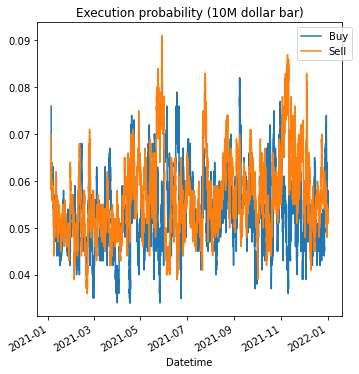

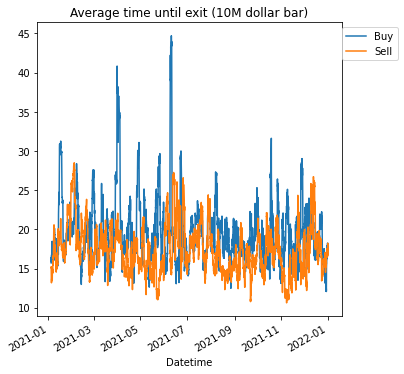

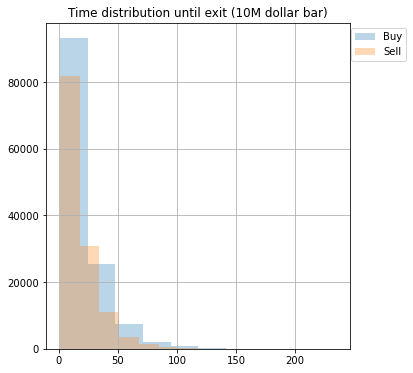

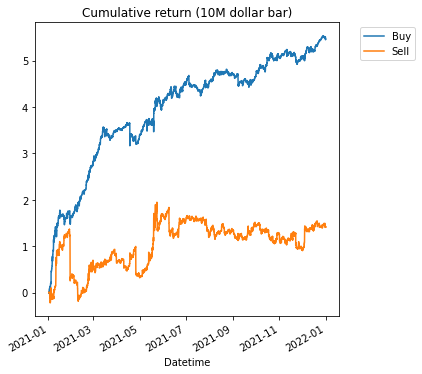

In [10]:
# Optunaの最適化結果に基づいて計算

# 最適化に利用したデータをテストデータとして表示する
df_dollar_optimized = pd.read_pickle('df_dollar_10000000_ohlcv_features.pkl')
df_dollar_optimized = calc_buysell(df_dollar_optimized, pips = 1, atr_mux = study.best_params['x'])
display_performance(df_dollar_optimized)

約定確率を可視化。時期によって約定確率が大きく変わると良くない。
エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。
毎時刻、この執行方法でトレードした場合の累積リターン
バーの数 5104本, 買い 258回, 売り 313回, 買った時のリターン平均 0.002 %, 売った時のリターン平均 0.005 %
リターンが0以上になる率 61.82136602451839 %
買いエントリーでリターンがプラスの回数 : 157
count    157.000000
mean       0.004139
std        0.003483
min        0.000043
25%        0.001627
50%        0.002927
75%        0.004977
max        0.017204
Name: y_buy, dtype: float64
売りエントリーでリターンがプラスの回数 196
count    196.000000
mean       0.004551
std        0.003809
min        0.000023
25%        0.001888
50%        0.003460
75%        0.005918
max        0.018595
Name: y_sell, dtype: float64


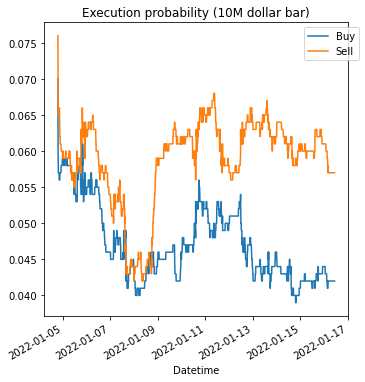

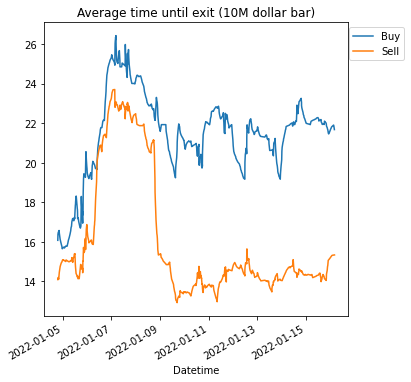

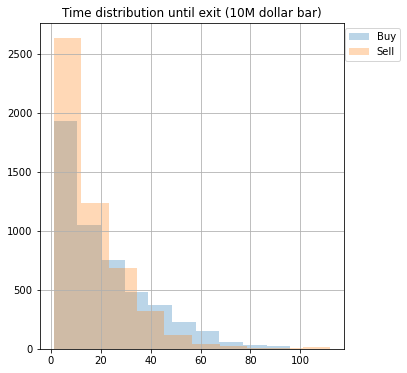

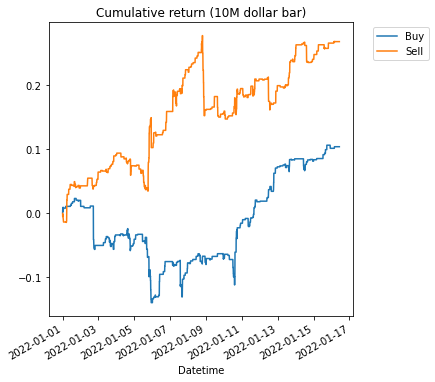

In [11]:
# Optunaの最適化結果に基づいて計算

# 2022年移行の最適化に利用していないデータをテストデータとして利用する
df_dollar_test = _dbutil.read_sql_query(sql = "SELECT * FROM \"ftx_btc-perp_dollarbar_10000000\" WHERE datetime >= '2022-01-01 00:00:00.000+00' ORDER BY dollar_cumsum ASC")
df_dollar_test = df_dollar_test[['datetime', 'datetime_from', 'open', 'high', 'low', 'close', 'dollar_volume', 'dollar_buy_volume', 'dollar_sell_volume', 'dollar_liquidation_buy_volume', 'dollar_liquidation_sell_volume', 'dollar_cumsum']]
df_dollar_test['fee'] = 0.00 / 100.0
df_dollar_test['delta_time'] = df_dollar_test['datetime'].diff().view(int) // 1_000_000
df_dollar_test['delta_time-1'] = 1.0 / df_dollar_test['delta_time']
df_dollar_test['dollar_buysell_ratio'] = df_dollar_test['dollar_buy_volume'] / df_dollar_test['dollar_sell_volume']
df_dollar_test = df_dollar_test[['datetime', 'open', 'high', 'low', 'close', 'dollar_volume', 'dollar_buy_volume', 'dollar_sell_volume', 'dollar_liquidation_buy_volume', 'dollar_liquidation_sell_volume', 'fee', 'delta_time', 'delta_time-1']]
df_dollar_test = df_dollar_test.dropna()
df_dollar_test.columns = ['Datetime', 'Open', 'High', 'Low', 'Close', 'dollar_volume', 'dollar_buy_volume', 'dollar_sell_volume', 'dollar_liquidation_buy_volume', 'dollar_liquidation_sell_volume', 'fee', 'delta_time', 'delta-time-1']
df_dollar_test = df_dollar_test.set_index("Datetime")

df_dollar_test = calc_buysell(df_dollar_test, pips = 1, atr_mux = study.best_params['x'])
display_performance(df_dollar_test)